# DataFix Demo

In [1]:
import torch
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from torch.distributions.multivariate_normal import MultivariateNormal
from datafix import DFLocate, DFCorrect

## Generate Dataset with Multivariate Gaussians

In [2]:
def _generate_mvg_dataset(
    n_samples, 
    loc1, 
    loc2, 
    scale_tril1, 
    scale_tril2, 
    cov1, 
    cov2, 
    n_corrupted, 
    transforms=None
):
    if scale_tril1 != None:
        p = MultivariateNormal(loc1, scale_tril=scale_tril1)
        q = MultivariateNormal(loc2, scale_tril=scale_tril2)
    else:
        p = MultivariateNormal(loc1, covariance_matrix=cov1)
        q = MultivariateNormal(loc2, covariance_matrix=cov2)
    
    if transforms != None:
        print('doing transforms', transforms)
        p = TransformedDistribution(p, transforms)
        q = TransformedDistribution(q, transforms)

    p_dset = p.sample((n_samples,)).numpy()
    q_dset = q.sample((n_samples,)).numpy()

    return p_dset, q_dset

def generate_mvg_dataset(
    n_dim, 
    n_corrupted, 
    n_samples, 
    mean_shift, 
    scale_shift, 
    shuffle_manipulation=None, 
    covariance_diagonal=True, 
    transforms=None, 
    p=2.0, 
    scale=10.0, 
    sequential=True
):

    loc1 = torch.zeros(n_dim)
    loc2 = torch.zeros(n_dim)
    loc2[0:n_corrupted] += mean_shift
       
    if not covariance_diagonal:
        cov1 = _get_cov_mat(n_dim, p=p, scale=scale, sequential=sequential)
        cov2 = cov1.clone()
        
        cov_shift = torch.zeros(n_dim)
        cov_shift[0:n_corrupted] += scale_shift
        cov2 = cov2 + torch.diag(cov_shift)
        
        scale1, scale2, scale_tril1, scale_tril2 = torch.zeros(1), torch.zeros(1), None, None
        
    else:
        scale1 = torch.ones(n_dim)
        scale2 = torch.ones(n_dim)
        scale2[0:n_corrupted] += scale_shift
        scale_tril1 = torch.diag(scale1)
        scale_tril2 = torch.diag(scale2)
        
        cov1, cov2 = None, None
    
    
    if shuffle_manipulation == 'feature-wise':
        for i in range(n_corrupted):
            cov2[i,(i+1):] = 0.0
            cov2[(i+1):,i] = 0.0
    elif shuffle_manipulation == 'sample-wise':
        for i in range(n_corrupted):
            cov2[i,n_corrupted:] = 0.0
            cov2[n_corrupted:,i] = 0.0
    
    
    p_dset, q_dset = _generate_mvg_dataset(
        n_samples, 
        loc1, 
        loc2, 
        scale_tril1, 
        scale_tril2, 
        cov1, 
        cov2, 
        n_corrupted, 
        transforms=transforms)

    dataset = {
        'ref':p_dset,'que':q_dset,
    }
    
    return dataset

To begin, we create the reference and query datasets for our analysis. These datasets are generated based on Multivariate Gaussians, using diagonal covariance and a shifted mean. Each dataset comprises 3000 samples and includes 100 features. In the query dataset, the **first 20 features** are **corrupted** by introducing a shift in the mean of 0.5.

In [3]:
torch.manual_seed(0)

n_dim = 50
n_corrupted = 20
shift = 0.5
n_samples = 1000

dataset = generate_mvg_dataset(
    n_dim, n_corrupted, n_samples, shift, 0.0, shuffle_manipulation=None, covariance_diagonal=True
)

reference = dataset['ref']
query = dataset['que']

## DFLocate

DataFix consists of two systems: ***DF-Locate***, which locates the features causing the distribution shift, and ***DF-Correct***, which modifies the query samples in order to decrease the distribution shift between the two datasets. Following, we create an instance of ***DFLocate*** with the specified input parameters. 

In [4]:
parameters = {
    "percentage" : 0.1,
    "step" : None,
    "alpha" : 1.0,
    "threshold" : None,
    "estimator" : RandomForestClassifier(random_state=0),
    "cv" : 5,
    "test_size" : None,
    "scoring" : 'balanced_accuracy',
    "n_jobs" : -1,
    "return_estimator" : False,
    "margin" : 0.01,
    "max_it" : None,
    "max_features_to_filter" : 0.5,
    "patience" : None,
    "random_state" : 0,
    "window_length" : 2,
    "polyorder" : 4,
    "S" : 5,
    "online" : False,
    "find_best" : 'knee-balanced',
    "verbose" : True
}

In [5]:
datafix_locate = DFLocate(**parameters)

### Shift Detection

The `shift_detection()` method can be used to identify if there is a distribution shift between a reference dataset and a query dataset. First, a discriminator is fit to distinguish between samples from the reference or the query. Then, the discriminator is evaluated on the test samples to determine if there is a divergence:

In [6]:
datafix_locate = datafix_locate.shift_detection(reference, query)

tvd=0.6780000000 


### Shift Location

The `shift_location()` method can be used to iteratively localize the corrupted features in the query that cause a distribution shift between the query and the reference datasets.

In [7]:
datafix_locate = datafix_locate.shift_location(reference, query)

iteration=1       | tvd=0.6780000000  | corrupted_features=2         
iteration=2       | tvd=0.6320000000  | corrupted_features=2         
iteration=3       | tvd=0.5900000000  | corrupted_features=2         
iteration=4       | tvd=0.5740000000  | corrupted_features=2         
iteration=5       | tvd=0.5290000000  | corrupted_features=2         
iteration=6       | tvd=0.4700000000  | corrupted_features=1         
iteration=7       | tvd=0.4460000000  | corrupted_features=1         
iteration=8       | tvd=0.4210000000  | corrupted_features=1         
iteration=9       | tvd=0.3810000000  | corrupted_features=1         
iteration=10      | tvd=0.3780000000  | corrupted_features=1         
iteration=11      | tvd=0.3150000000  | corrupted_features=1         
iteration=12      | tvd=0.2700000000  | corrupted_features=1         
iteration=13      | tvd=0.2630000000  | corrupted_features=1         
iteration=14      | tvd=0.1800000000  | corrupted_features=1         
iteration=15      | 

As a result, the ***mask*** of corrupted features is stored, where 1 indicates a variable is corrupted and 0 indicates it is not.

In [8]:
mask = datafix_locate.mask_
mask

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

Another attribute worth noting is the ***ranking***, which indicates the iteration number at which each feature is identified as corrupted. Features that are not corrupted are assigned a value of zero.

In [9]:
ranking = datafix_locate.ranking_
ranking

array([11, 12,  2,  3,  6,  7,  5, 10,  4,  2,  5, 15,  1,  4, 14,  9,  1,
        8, 13,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [10]:
n_corrupted_features = datafix_locate.n_corrupted_features_

print(f"{n_corrupted_features} corrupted features in the query!")

20 corrupted features in the query!


### Plot Evolution

The ``plot_evolution()`` method can be used to plot the evolution curve of the ***Total Variation Divergence (TVD)*** versus the number of corrupted features removed. Additionally, when ``find_best='knee-balanced'``, it also plots the iteration or knee with the correct number of corrupted features and the smoothed TVD from which the knee is identified.

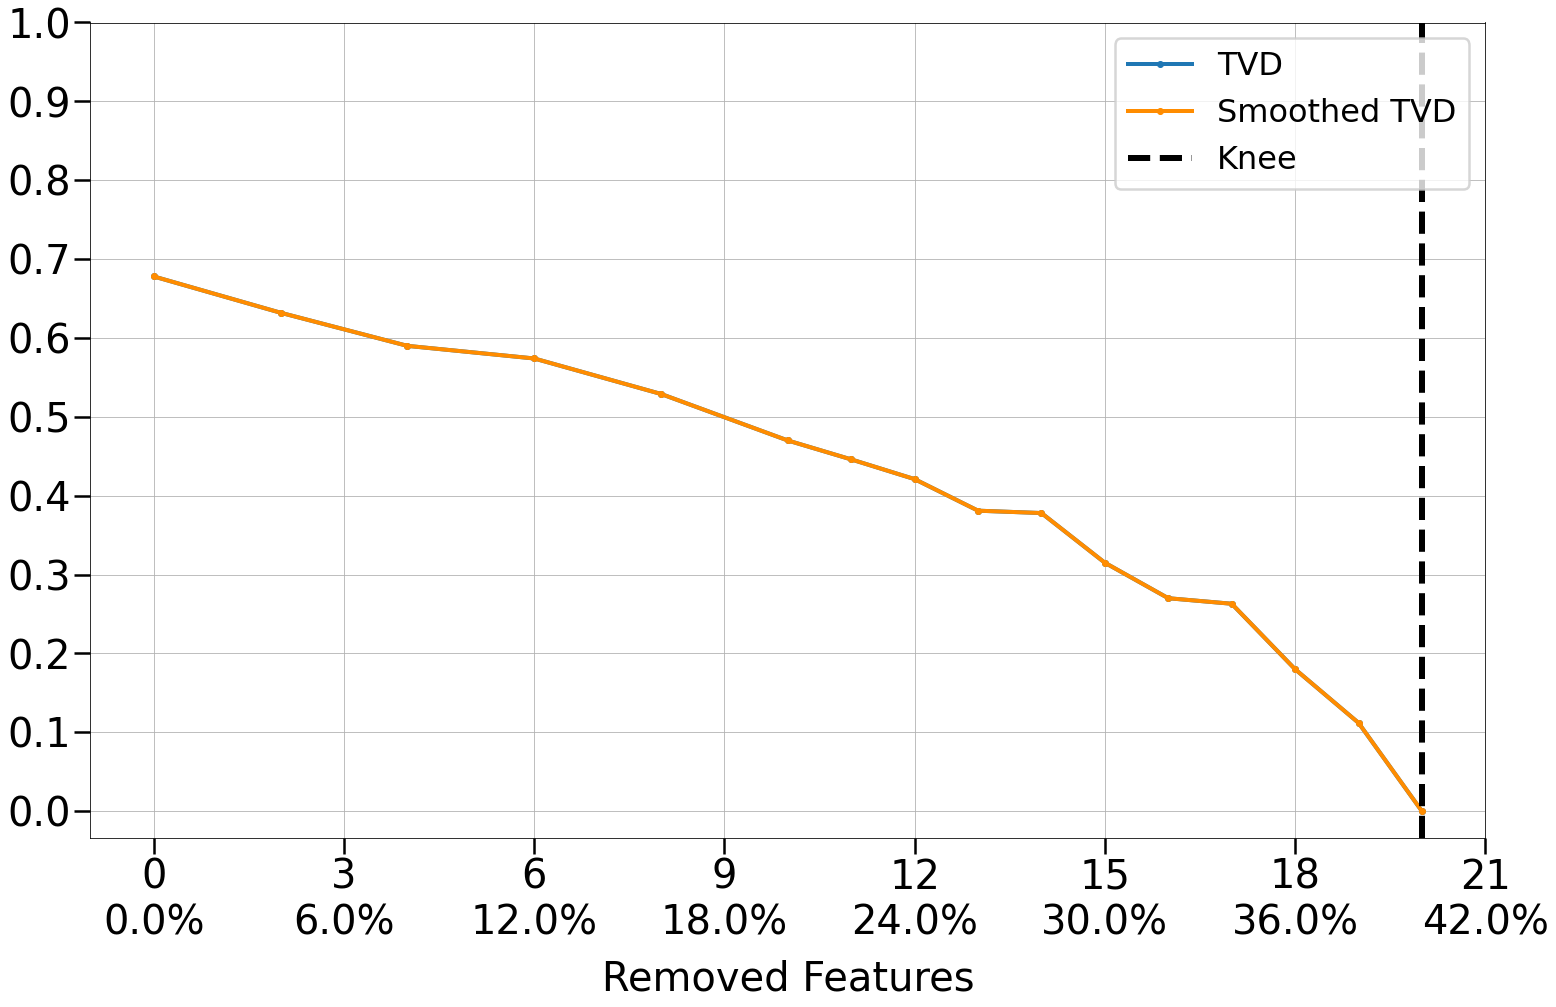

In [11]:
datafix_locate.plot_evolution()

The ***F1 score*** curve in the localization of the corrupted features can be optionally plotted. Below is an example of code that calculates and plots the F1 Score for the localized features at each iteration.

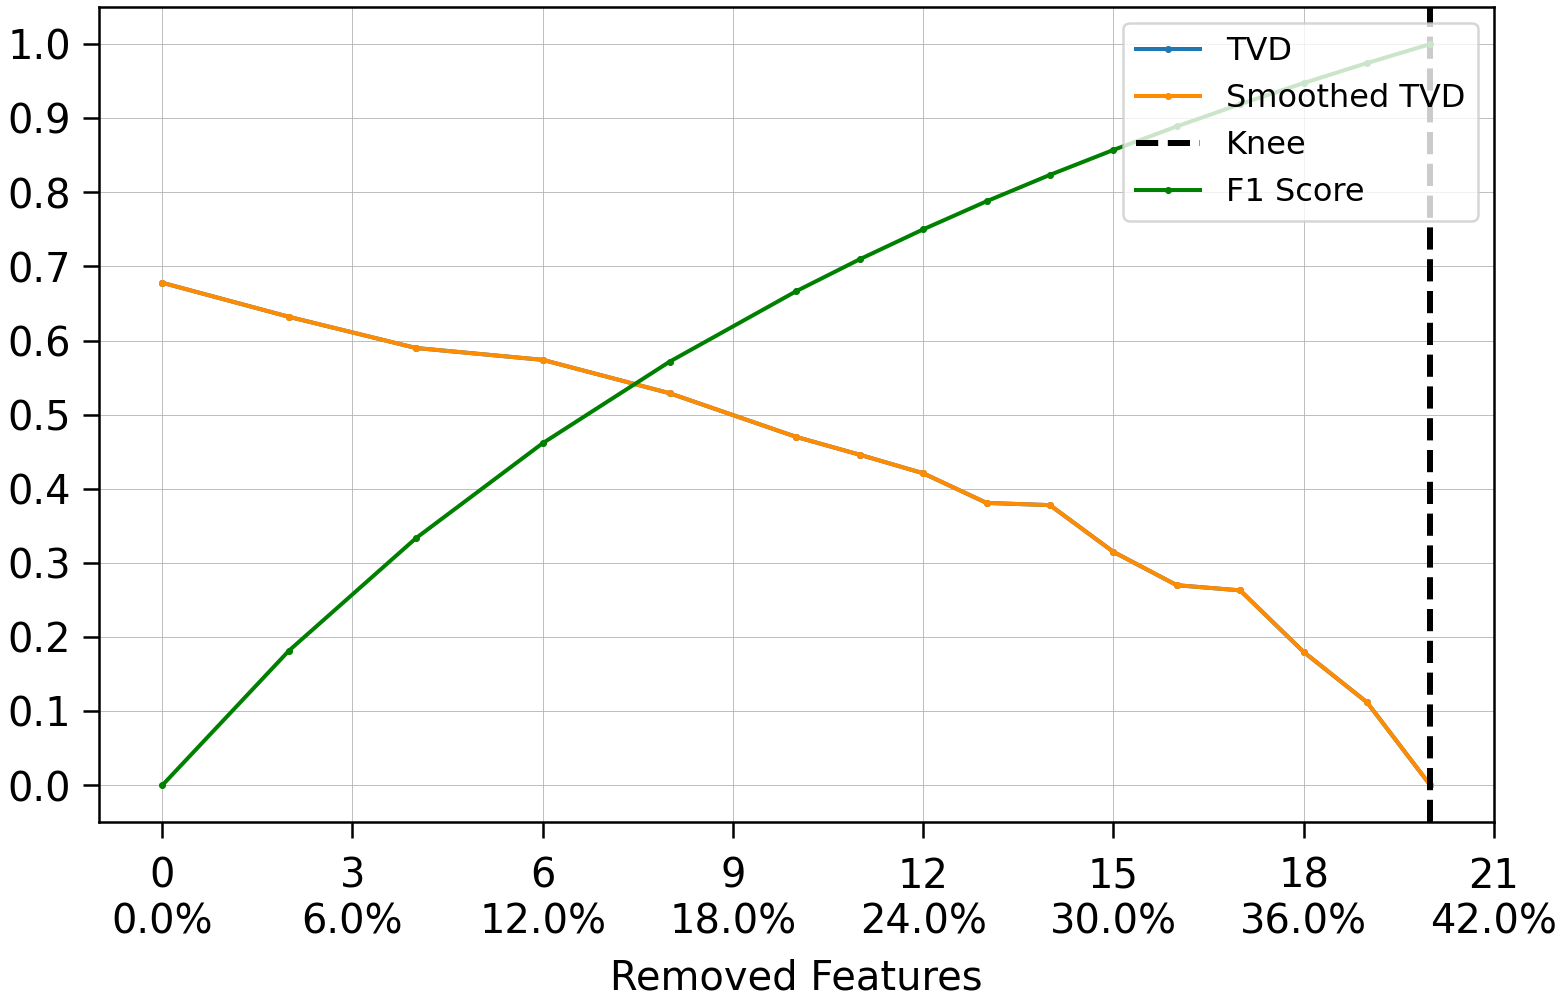

In [12]:
from sklearn.metrics import f1_score

# Compute the array of true labels where 1 indicates a variable is corrupted and 0 indicates it is not
y_true = np.zeros(50)
y_true[:20] = 1

f1_scores = []
mask_it = np.zeros(50)
for i in range(1, datafix_locate.n_iters_+1):
    f1_it = f1_score(y_true, mask_it, zero_division=1)
    f1_scores.append(f1_it)
    mask_it[datafix_locate.ranking_ == i] = 1
    
datafix_locate.plot_evolution(f1_score=f1_scores)

## DFCorrect

Next, we instantiate an object of ***DFCorrect*** with the specified parameters.

In [38]:
parameters = {
    "base_classifier" : CatBoostClassifier(verbose=False, random_state=0),
    "batch_size" : 5000,
    "max_dims" : None,
    "num_epochs" : 1,
    "random_seed" : 0,
    "verbose" : False
}

The `fit_transform()` method can be used to correct the corrupted features detected by DF-Locate. The inputs to the function are the reference dataset, the query dataset, and the ***mask*** of corrupted features computed by DF-Locate, where 1 indicates a variable is corrupted and 0 indicates it is not.

In [42]:
datafix_correct = DFCorrect(**parameters)
query_corrected = datafix_correct.fit_transform(reference, query, mask)

print("Finished correcting query!")

Finished correcting query!
